# ANLY 515 — Risk Modeling and Optimization of a Multi-Sector Equity Portfolio

This notebook implements a minimal, clean experiment that runs top-to-bottom with no unnecessary complexity.


## 1) Environment & Setup

Install and import only the required libraries, set a seed, and silence warnings.


In [1]:
# Install required packages
!pip install -q numpy pandas matplotlib seaborn yfinance scipy


In [2]:
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize

# Silence warnings for clean output
warnings.filterwarnings("ignore")

# Reproducibility
SEED = 319302
np.random.seed(SEED)

# Plot styling
plt.rcParams["figure.figsize"] = (10, 5)


## 2) Data Collection

Download daily adjusted close prices from Yahoo Finance and clean missing values.


In [3]:
# Sector definitions and tickers
sectors = {
    "Technology": ["AAPL", "MSFT"],
    "Financials": ["JPM", "BAC"],
    "Healthcare": ["JNJ", "PFE"],
}

all_tickers = [t for tickers in sectors.values() for t in tickers]
start_date = "2020-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

# Download adjusted close prices
prices = yf.download(
    all_tickers,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    progress=False,
)["Adj Close"]

# Ensure DataFrame
if isinstance(prices, pd.Series):
    prices = prices.to_frame(name=all_tickers[0])

# Drop missing values
prices = prices.dropna()

# Basic validation
assert not prices.empty, "Price data is empty. Check ticker symbols or network access."
assert prices.shape[1] == 6, "Expected 6 assets after download."

print(f"Downloaded price data: {prices.shape[0]} rows x {prices.shape[1]} columns")
prices.head()


Downloaded price data: 1532 rows x 6 columns


Ticker,AAPL,BAC,JNJ,JPM,MSFT,PFE
Date,,,,,,
2020-01-02,72.468277,30.760485,123.290192,119.036423,152.505737,27.494844
2020-01-03,71.763733,30.121790,121.862762,117.465561,150.606720,27.347328
2020-01-06,72.335548,30.078634,121.710732,117.372177,150.996017,27.312202
2020-01-07,71.995361,29.880125,122.453972,115.376762,149.619247,27.220882
2020-01-08,73.153496,30.182207,122.437141,116.276817,152.002518,27.438648


## 3) Return Computation

Compute daily log returns for each asset.


In [4]:
log_returns = np.log(prices / prices.shift(1)).dropna()

assert not log_returns.empty, "Log returns are empty after computation."

print(f"Log returns: {log_returns.shape[0]} rows x {log_returns.shape[1]} columns")
log_returns.head()


Log returns: 1531 rows x 6 columns


Ticker,AAPL,BAC,JNJ,JPM,MSFT,PFE
Date,,,,,,
2020-01-03,-0.009770,-0.020982,-0.011645,-0.013284,-0.012530,-0.005380
2020-01-06,0.007936,-0.001434,-0.001248,-0.000795,0.002582,-0.001285
2020-01-07,-0.004714,-0.006622,0.006088,-0.017147,-0.009160,-0.003349
2020-01-08,0.015958,0.010059,-0.000137,0.007771,0.015803,0.007968
2020-01-09,0.021018,0.001714,0.002962,0.003645,0.012415,-0.004362


## 4) Descriptive Risk Statistics

Compute mean, volatility, and correlation for assets, sectors, and the total portfolio.


Asset-level statistics


,mean,volatility
Ticker,,
AAPL,0.000873,0.019926
BAC,0.000379,0.021556
JNJ,0.000429,0.012347
JPM,0.000626,0.019690
MSFT,0.000619,0.018803
PFE,-0.000024,0.017090


Sector and total portfolio statistics


,mean,volatility
Technology,0.000746,0.017824
Financials,0.000502,0.020001
Healthcare,0.000202,0.012896
Total,0.000484,0.013287


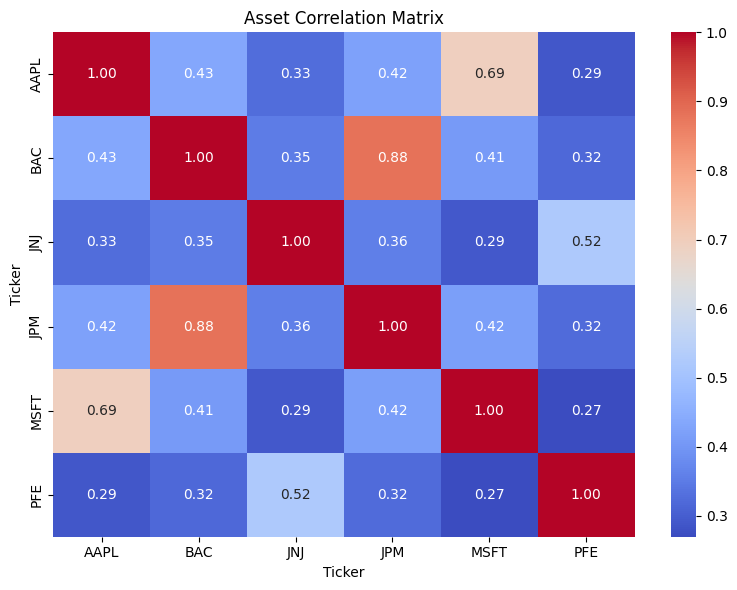

In [5]:
# Asset-level stats
asset_stats = pd.DataFrame({
    "mean": log_returns.mean(),
    "volatility": log_returns.std(),
})
print("Asset-level statistics")
display(asset_stats)

# Sector portfolios (equal-weight within sector)
sector_returns = pd.DataFrame({
    sector: log_returns[tickers].mean(axis=1)
    for sector, tickers in sectors.items()
})

# Total portfolio (equal-weight across all assets)
portfolio_return = log_returns.mean(axis=1)

portfolio_stats = pd.DataFrame({
    "mean": sector_returns.join(portfolio_return.rename("Total")).mean(),
    "volatility": sector_returns.join(portfolio_return.rename("Total")).std(),
})

print("Sector and total portfolio statistics")
display(portfolio_stats)

# Correlation heatmap (assets)
correlation = log_returns.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Asset Correlation Matrix")
plt.tight_layout()
plt.show()


## 5) Value at Risk (VaR)

Compute 95% historical and parametric (normal) VaR for sector portfolios and total portfolio.


In [6]:
def historical_var(series, alpha=0.95):
    return -np.quantile(series, 1 - alpha)


def parametric_var(series, alpha=0.95):
    mu = series.mean()
    sigma = series.std()
    z = stats.norm.ppf(1 - alpha)
    return -(mu + sigma * z)


portfolios = sector_returns.copy()
portfolios["Total"] = portfolio_return

var_rows = []
for name in portfolios.columns:
    s = portfolios[name]
    var_rows.append({
        "portfolio": name,
        "VaR_hist_95": historical_var(s, 0.95),
        "VaR_norm_95": parametric_var(s, 0.95),
    })

var_table = pd.DataFrame(var_rows).set_index("portfolio")
print("95% VaR (historical and normal)")
display(var_table)


95% VaR (historical and normal)


,VaR_hist_95,VaR_norm_95
portfolio,,
Technology,0.027519,0.028572
Financials,0.029176,0.032396
Healthcare,0.018461,0.021009
Total,0.018134,0.021372


## 6) Conditional Value at Risk (CVaR)

Compute 95% historical CVaR for sector portfolios and total portfolio.


In [7]:
def historical_cvar(series, alpha=0.95):
    q = np.quantile(series, 1 - alpha)
    tail = series[series <= q]
    return -tail.mean()

cvar_rows = []
for name in portfolios.columns:
    s = portfolios[name]
    cvar_rows.append({
        "portfolio": name,
        "CVaR_hist_95": historical_cvar(s, 0.95),
    })

cvar_table = pd.DataFrame(cvar_rows).set_index("portfolio")
print("95% CVaR (historical)")
display(cvar_table)


95% CVaR (historical)


,CVaR_hist_95
portfolio,
Technology,0.041181
Financials,0.045591
Healthcare,0.028361
Total,0.031366


## 7) Monte Carlo Simulation

Simulate 10,000 portfolio returns using a multivariate normal model and plot VaR/CVaR.


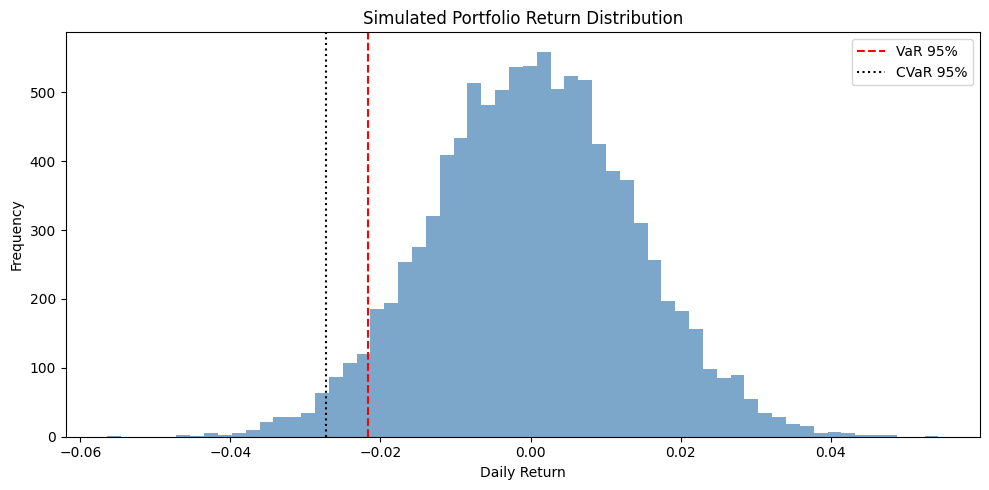

In [8]:
mu = log_returns.mean().values
cov = log_returns.cov().values
n_sims = 10_000

weights_equal = np.ones(len(all_tickers)) / len(all_tickers)

simulated = np.random.multivariate_normal(mu, cov, size=n_sims)
sim_portfolio = simulated @ weights_equal

var_return = np.quantile(sim_portfolio, 0.05)
cvar_return = sim_portfolio[sim_portfolio <= var_return].mean()

plt.figure(figsize=(10, 5))
plt.hist(sim_portfolio, bins=60, color="steelblue", alpha=0.7)
plt.axvline(var_return, color="red", linestyle="--", label="VaR 95%")
plt.axvline(cvar_return, color="black", linestyle=":", label="CVaR 95%")
plt.title("Simulated Portfolio Return Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


## 8) Portfolio Optimization (Simple)

Minimize portfolio variance with long-only weights and compare to equal-weight risk.


In [9]:
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

n_assets = len(all_tickers)

# Constraints: weights sum to 1, no shorting
constraints = ({"type": "eq", "fun": lambda w: np.sum(w) - 1})
bounds = [(0.0, 1.0) for _ in range(n_assets)]

initial = np.ones(n_assets) / n_assets

result = minimize(
    portfolio_variance,
    initial,
    args=(cov,),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

assert result.success, f"Optimization failed: {result.message}"

weights_opt = result.x

risk_equal = np.sqrt(portfolio_variance(initial, cov))
risk_opt = np.sqrt(portfolio_variance(weights_opt, cov))

risk_compare = pd.DataFrame({
    "portfolio": ["Equal-weight", "Optimized"],
    "volatility": [risk_equal, risk_opt],
}).set_index("portfolio")

print("Equal-weight vs optimized portfolio risk")
display(risk_compare)

weights_table = pd.DataFrame({
    "Equal-weight": initial,
    "Optimized": weights_opt,
}, index=all_tickers)

print("Optimized weights")
display(weights_table)


Equal-weight vs optimized portfolio risk


,volatility
portfolio,
Equal-weight,0.013287
Optimized,0.013287


Optimized weights


,Equal-weight,Optimized
AAPL,0.166667,0.166667
MSFT,0.166667,0.166667
JPM,0.166667,0.166667
BAC,0.166667,0.166667
JNJ,0.166667,0.166667
PFE,0.166667,0.166667


## 9) Sector Risk Attribution (Simple)

Compute each sector’s contribution to total portfolio variance (equal-weight portfolio).


In [10]:
# Asset-level variance contributions for equal-weight portfolio
port_var = portfolio_variance(initial, cov)
marginal = cov @ initial
asset_contrib = initial * marginal / port_var

contrib_table = pd.DataFrame({
    "asset": all_tickers,
    "variance_contribution": asset_contrib,
})

# Map asset contributions to sector totals
sector_contrib = {}
for sector, tickers in sectors.items():
    sector_contrib[sector] = contrib_table[contrib_table["asset"].isin(tickers)]["variance_contribution"].sum()

sector_contrib_table = pd.DataFrame.from_dict(sector_contrib, orient="index", columns=["variance_contribution"])

print("Sector variance contribution (equal-weight portfolio)")
display(sector_contrib_table)


Sector variance contribution (equal-weight portfolio)


,variance_contribution
Technology,0.407044
Financials,0.294011
Healthcare,0.298945
